# Grover Adaptative Search (GAS)

## Bibliografía

[Qiskit Optimización](https://github.com/qiskit-community/qiskit-optimization): Aquí dentro están los algoritmos que implementan los algoritmos de optimización de QiSkit

[*Grover Adaptative Search for Constrained Polynomial Binary Optimization*](https://arxiv.org/pdf/1912.04088): Paper donde se explica el algoritmo

[Grover Optimizer](https://qiskit-community.github.io/qiskit-optimization/tutorials/04_grover_optimizer.html): Aquí se indice cómo usar el código que aparece debajo

In [1]:
# Indicar si estamos en Colab o no (por ejemplo Jupyter)
colab = False

# SI ESTÁS EN COLAB -> CAMBIAR Y PONER TU RUTA DE DRIVE HASTA LA CARPETA DE TODOS LOS ARCHIVOS
ruta_base = '/content/drive/My Drive/Quantum/GAS/'

In [2]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    subruta = 'Imágenes gas/'

In [4]:
if colab:
  !pip install qiskit==1.0.1
  !pip install qiskit_algorithms==0.3.0
  !pip install qiskit_optimization==0.6.1
  !pip install docplex # Librerías para crear el modelo y ejecutar GAS

In [19]:
# from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import GroverOptimizer
# from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model # Las librerías comentadas es por si visitais la página de Grover Optimizer y queréis comprobar la solución exacta
from IPython.display import display,Markdown,Latex,Image # Para Latex, enseñar imágenes, etc.
import numpy as np # Cálculos, matrices...

## 1. Explicación Teórica

Ya vimos que el propósito del algoritmo de Grover es encontrar un elemento (o uno de un subconjunto) de interés en un conjunto desordenado de forma eficiente. Sin embargo, no se puede aplicar per sé para resolver problemas de optimización combinatoria. Por ello, se ha creado recientemente un algoritmo llamado **Grover Adaptative Search** (basado en el Algoritmo de Grover) el cual sí que resuelve problemas de *optimización combinatoria de orden dos sin restricciones* (aunque extensible a órdenes mayores y con restricciones). Sin embargo, puntualizar que el algoritmo que usaremos después (implementado por IBM a través de Qiskit) sólo puede resolver problemas cuya función objetivo tenga con restricciones lineales. 

Para entender los conceptos relacionados con este nuevo algoritmo, se recomienda encarecidamente entender el funcionamiento del algoritmo de Grover acudiendo al cuaderno con dicho nombre. 

### 1.1 Introducción

En el algoritmo de Grover, teníamos un operador que ahora llamaremos $A$ que era aplicar una puerta de **Walsh-Hadamard** a los $n$ cubits (para que estuvieran en *superposición*), de forma que:

$$
A|0\rangle_n = H^{\otimes n}|0\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n-1} |i\rangle_n
$$

También teníamos un operador $O$ que representaba el **oráculo**, el cual *reconocía los estados que nos interesaban* y *multiplicaba sus amplitudes por* $-1$. En consecuencia, si $I \subset \{0, ..., 2^n-1\}$ es el conjunto de estados objetivo, entonces:

$$
OA|0\rangle_n = \frac{1}{\sqrt{2^n}}\sum_{i \notin I} |i\rangle_n - \frac{1}{\sqrt{2^n}}\sum_{i \in I} |i\rangle_n
$$

Y por último, teníamos el operador de **difusión** $D$ que *multiplicaba la amplitud del estado* $|0\rangle_n$ (o de forma equivalente, todos los estados salvo $|0\rangle_n$) *por* $-1$. Es decir, el operador $D$ hacía la *reflexión sobre la media de las amplitudes*. 

Entonces, definíamos el **operador de Grover** $G$ como $G=ADA^{\dagger}O$, el cual lo aplicábamos un número determinado de veces ($r$) a $A|0\rangle_n$ para *maximizar las amplitudes de los estados que nos interesan*. 

El GAS se apoya en los conceptos de este algoritmo para resolver problemas de optimización. 

Vamos a considerar una función $f: X \rightarrow \mathbb{R}$ para $n$ variables binarias, donde asumimos por simplificar que $X = \{0,1\}^n$, para el cual queremos hallar $min_{x \in X} \ f(x)$. La idea principal de GAS es construir **dos operadores** $A_y$ y $O_y$ para un determinado valor $y$ (denominado **umbral**) para el que conseguimos *identificar aquellos estados* $x \in X$ *tales que* $f(x)<y$ (porque son los que nos interesan al querer minimizar). Esto nos sirve para encontrar una solución $x_i$ con un menor valor en la función objetivo que $y$. Después establecemos el nuevo umbral $y = f(x_i)$ y seguimos iterando hasta que no se obtengan mejoras. 

Vamos a considerar dos conjuntos de cubits: por un lado, $n$ cubits que representan las **variables binarias** (esto es igual en Grover) y por otro lado y como novedad, $m$ cubits que van a representar el **registro de salida**, y que servirán para *almacenar los resultados de los valores de funciones*. El **último** cúbit de este grupo almacenará el *signo* del valor. 

Entonces, el operador $A_y$ lo que va a hacer es es preparar los $n$ cubits para que estén en **superposición** $(|x\rangle_n)$, y prepara los $m$ cubits para representar aproximadamente la **diferencia de la función con el umbral** $(|f(x)-y\rangle_m)$. Después, el operador $O_y$ lo que va a hacer simplemente es **señalar** los estados con un valor negativo ($f(x)<y$) en el registro de salida $m$. Las expresiones matemáticas relacionadas con estos dos operadores son:

$$
A_y|0\rangle_n |0\rangle_m = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle_n |f(x)-y\rangle_m
$$

$$
O|x\rangle_n|z\rangle_m = sign(z)|x\rangle_n|z\rangle_m
$$

Siendo $|x\rangle$ la representación binaria del entero $x$ y $|z\rangle_m = |f(x)-y\rangle_m$

### 1.2 Operador $A_y$

Este operador que actúa tanto en los $n$ como los $m$ cubits se basa en tres "sub-operadores": puertas **Hadamard** $H$, la **transformada de Fourier cuántica inversa** $QFT^{\dagger}$ y un nuevo operador denominado $U_G(\theta)$.

#### 1.2.1 $U_G(\theta)$

Dado un registro de $m$ cubits y un ángulo $\theta \in [-\pi, \pi)$, queremos preparar un estado cuántico cuyo vector de estado represente una *señal periódica* equivalente a una secuencia geométrica de longitud $2^m$. Esto lo hacemos gracias a $U_G(\theta)$.

La base de este operador es la **puerta de fase** $R(\theta)$ que cuando se aplica a un cúbit, *rota la fase de las amplitudes de los estados con el valor* $1$ *en la posición correspondiente* a ese cúbit. El circuito asociado a este operador consiste en aplicar la puerta $R(2^i \theta)$ al cúbit $m-1-i$, con $m = 0,...,m-1$. 

Recordar que $R(\theta) = \begin{pmatrix}1 & 0 \\ 0 & e^{i\theta} \end{pmatrix}$.

**Atención**: El término $i$ de antes **no es el número imaginario**, sino un índice.

La representación visual de este operador es la siguiente:

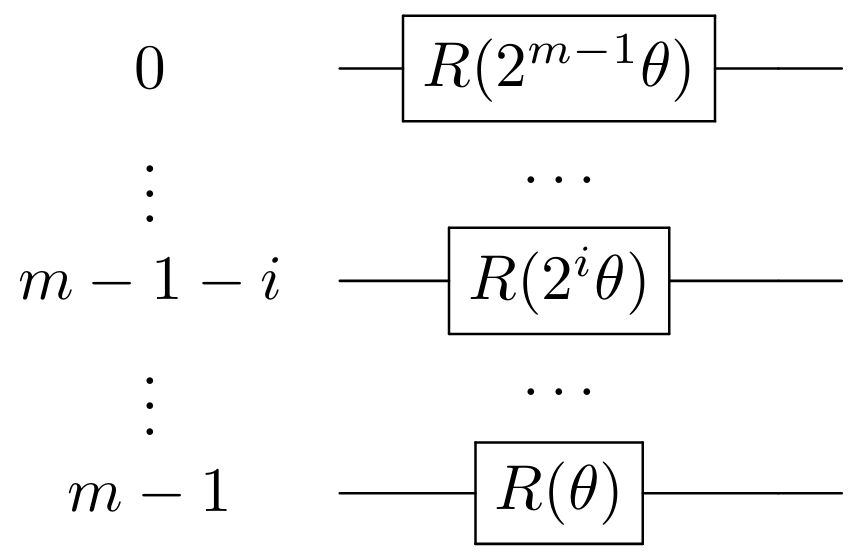

In [6]:
if colab:
    display(Image(filename = ruta_base + subruta + '1_rotar.png'))
else:
    display(Image(filename='./Imágenes gas/1_rotar.png'))

Por ejemplo, si $m = 3$, al primer cúbit del registro de $m$ cubits le aplicamos $R(2^2 \theta) = R(4\theta)$, al segundo $R(2^1 \theta) = R(2\theta)$, y al último $R(2^0 \theta) = R(\theta)$. 

Esto crea un patrón de fases binario: el cúbit menos significativo recibe la rotación más pequeña ($2^0 𝜃$), y el más significativo recibe la mayor ($2^{m − 1}𝜃$). Esto es esencial para *codificar un número binario en fases* y luego poder *leerlo* con la $QFT$ inversa (propio de la *estimación de fase*).

**Nota**: Si se quiere ver una implementación alternativa para este operador, ir al Paper original, apéndice A.

¿Y qué es $\theta$? Pues $\theta = \frac{2\pi}{2^m}k$, siendo $k$ un entero entre $-2^{m-1}$ y ${2^{m-1}}$ (nos reservamos el último cúbit para el signo) que explicaremos después como funciona. 

#### 1.2.2 Operador $A$

Gracias a esto, si aplicamos $U_G(\frac{2\pi}{2^m} k)$ junto a la transformada de Fourier cuántica inversa a un registro de $m$ cubits en superposición, obtenemos un registro igual a $k \ (mod \ 2^m)$. 

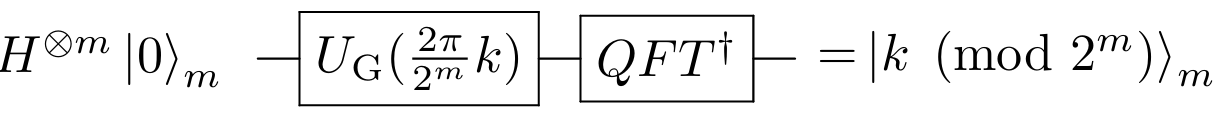

In [7]:
if colab:
    display(Image(filename = ruta_base + subruta + '2_secuencia.png'))
else:
    display(Image(filename='./Imágenes gas/2_secuencia.png'))

Esta representación que obtenemos al final se conoce como **Binary Two's Complement of** $k$. En realidad lo que hace es añadir $2^m$ a los valores negativos $k$, de forma parecida a la forma que representamos ángulos negativos con su complemento (por ejemplo, $-\frac{\pi}{4} = \frac{7\pi}{4}$).

¿Y cómo recuperamos el valor original? Porque ahora sólo tenemos valores positivos desde $0$ hasta $2^{m}-1$ y codificamos valores $k$ tales que $-2^{m-1} \leq k \leq 2^{m-1}$... Pues si el número que recibimos tras la salida de la $QFT^{\dagger}$ es *mayor o igual a* $2^{m-1}$, es porque en realidad *era negativo y le hemos sumado* $2^m$. Entonces para *recuperar el original* tenemos que *restar* $2^m$.

Antes de explicar qué es $k$, vamos a explicar dos conceptos que nos ayudarán a comprender mejor la implementación del operador $A_y$. 

El primer concepto es que un **polinomio de** $n$ **variables** (tales como tendremos en la función objetivo) se puede *expresar* de la siguiente forma:

$$
P(x) = \sum_{J \subseteq \{0, ..., n-1\}} a_J \prod_{j \in J}x_j
$$

Por ejemplo, si tenemos dos variables, $x_0, x_1$, podemos formar los siguientes monomios: $1, x_0,x_1,x_0x_1$. Y si tenemos tres variables, $x_0,x_1,x_2$, podremos formar $1,x_0,x_1,x_2,x_0x_1,x_0x_2,x_1x_2,x_0x_1x_2$. Lo importante es que cada monomio tiene su coeficiente, incluso $1$, cuyo coeficiente es $a_\emptyset$. De esta forma, en el primer ejemplo, tendremos los siguientes coeficientes: $a_\emptyset, a_0,a_1,a_{01}$.

El segundo concepto es que, de forma general, la **aplicación** de un **operador unitario** $U$ a $|z\rangle_m$ **controlado** por un subconjunto de cubits $J \subseteq \{0,...,n-1\}$ de $|x\rangle_n$ tiene la notación matemática $C^J(U)$ y es igual a:

$$
C^J(U)|x\rangle|z\rangle=|x\rangle U^{\prod_{j \in J}x_j}|z\rangle
$$

Y en nuestro caso, el operador unitario es $U_G(\frac{2\pi}{2^m}k)$, con $k=a_J$, es decir, el *coeficiente del monomio* que estemos considerando en este momento. Por ejemplo, si tenemos $n=4$ cubits de consulta y consideramos el monomio $2x_1x_3$, el circuito asociado será el siguiente:

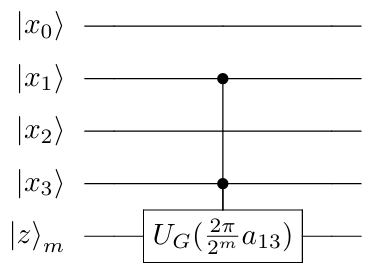

In [8]:
if colab:
    display(Image(filename = ruta_base + subruta + '3_a13.png'))
else:
    display(Image(filename='./Imágenes gas/3_a13.png'))

Siendo $a_{13} = 2$ (el coeficiente). Y si el registro de salida tiene $m=3$ cúbits, entonces podemos ya especificar cómo será el operador $U_G$. En el primer cúbit de salida tendremos:

$$
R(2^{m-1}\frac{2\pi}{2^m}a_{13}) = R(2^2 \frac{2\pi}{2^3}2) = R(2\pi)
$$

En el segundo cúbit tendremos:

$$
R(2^{m-2}\frac{2\pi}{2^m}a_{13}) = R(2^1 \frac{2\pi}{2^3}2) = R(\pi)
$$

Y en el último tendremos:

$$
R(2^{m-3}\frac{2\pi}{2^m}a_{13}) = R(2^0 \frac{2\pi}{2^3}2) = R(\frac{\pi}{2})
$$

Todos controlados por los cúbits de consulta $x_1$ y $x_3$.

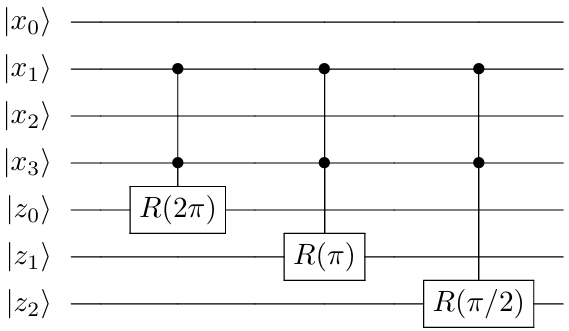

In [10]:
if colab:
    display(Image(filename = ruta_base + subruta + '4_ej.png'))
else:
    display(Image(filename='./Imágenes gas/4_ej.png'))

Aún nos queda un poquito para definir completamente el operador $A_y$. Primero vamos a definir el operador $A$ (sobre el cual construiremos $A_y$) como:

- Aplicar puertas **Hadamard** a los $n + m$ cubits de *ambos registros*.
- Aplicar una **puerta** $U_G(\frac{2\pi}{2^m}a_J)$ por *cada monomio* de la función objetivo, **controlado** por el conjunto de cubits correspondientes en el *registro de consulta* y su **efecto** en el conjunto de $m$ cubits de *salida*.
- La **Transformada de Fourier Cuántica inversa** en los $m$ cubits de *salida*. 

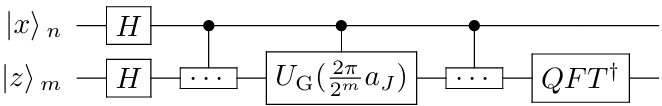

In [12]:
if colab:
    display(Image(filename = ruta_base + subruta + '5_a.png'))
else:
    display(Image(filename='./Imágenes gas/5_a.png'))

Entonces, lo que hace el operador $A$ es preparar un estado donde el registro $|x\rangle_n$ representa los $2^n$ estados en *superposición*, estando *entrelazados* con los correspondientes *valores del polinomio* de la función objetivo $P(x)$ codificados en el registro $|z\rangle_m$. 

$$
A|0\rangle_n |0\rangle_m = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle_n|P(x)\rangle_m
$$

¿Y cómo pasamos de $A$ a $A_y$? Añadiendo la constante del umbral $y$ al término independiente del polinomio original $a_{\emptyset}$. 

**Nota**: Es importante determinar el **número exacto** $m$ **de cubits** del **registro de salida** (teniendo en cuenta que uno de ellos va a ser para el signo). Si te quedas corto, no vas a poder determinar todos los valores posibles de la función, y si te pasas, es esfuerzo computacional innecesario.

### 1.2 Operador $O_y$

Hemos explicado que en cada paso del algoritmo, *añadimos una constante al polinomio*, y buscamos los *resultados de signo negativo*. Entonces el **oráculo** simplemente tiene que *reconocer los enteros de signo negativo*. Como los valores vienen representados por la codificación binaria, hay un *cúbit que determina el signo del número*. Se puede usar ese cúbit para reconocer los enteros negativos y *multiplicar sus amplitudes* por $-1$ (como en el algoritmo de Grover). 

Una pequeña **observación**: el oráculo no cambia entre iteraciones, pero estamos añadiendo al operador $A_y$ una constante $y_i$ en cada iteración. Entonces puede ocurrir que los $m$ cubits que habías pensado como suficientes para representar los valores de la función en verdad no lo sean... Entonces, *añadir uno más por si acaso*. 

### 1.3 Restricciones

Normalmente, los problemas de optimización vienen con **restricciones** que *reducen el espacio de búsqueda del registro de consulta*. Afortunadamente, se pueden implementar *operadores similares* a los de antes para considerar restricciones. Eso sí, por cada restricción habrá que **añadir un cúbit adicional** para comprobar *si se cumple o no la restricción*. Y además, habrá que añadir **otro cúbit adicional** porque tendremos que comprobar que *se cumplen a la vez todas las restricciones y que* $f(x)<y$.

Distinguimos los casos de **desigualdad** y de **igualdad**. Los *primeros* son más sencillos, puesto que tienen la forma $C(x)<0$ (si fuera $C(x) \leq 0$, haríamos $C(x)-1<0$), y se implementan de la *misma forma que la función objetivo* (en la función objetivo hacíamos $f(x)<y$). Los *segundos* son más complicados, y hay *dos formas* de implementarlos: o bien *detectar los estados válidos* con un *operador de difusión* $D$ *de Grover*, o bien añadir un *término de penalización a la función objetivo*. Además, este tipo de restricciones no le suelen gustar al algoritmo (suele ir peor). 

**Nota**: Después de aplicar el operador $A_y$ / $D$ bien sea para una restricción o para la función objetivo, ¡luego hay que implementar el **operador inverso** para "dejar todo como estaba"!

Un ejemplo de una iteración de la búsqueda de Grover de un problema con una restricción es el siguiente: 

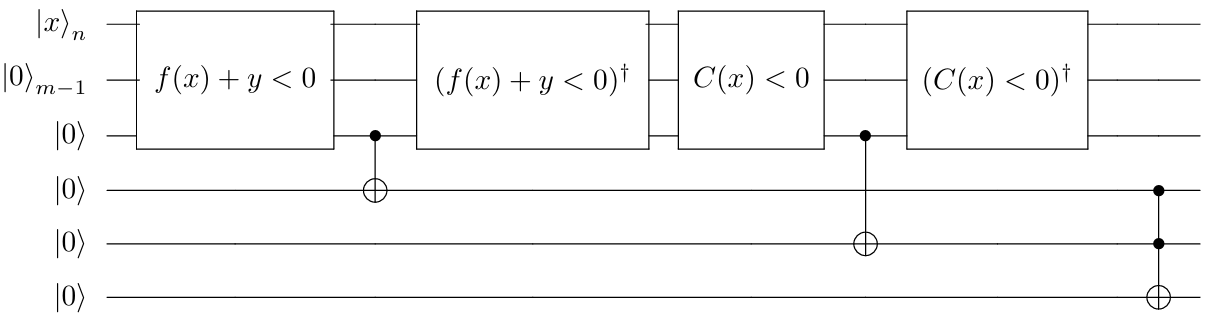

In [13]:
if colab:
    display(Image(filename = ruta_base + subruta + '6_circuito.png'))
else:
    display(Image(filename='./Imágenes gas/6_circuito.png'))

### 1.4 Pseudocódigo

Los pasos son los siguientes: Introducimos como inputs las *variables* de nuestro problema (junto con la función objetivo y las restricciones), e introducimos un *parámetro* $\lambda >1$ que nos ayudará a indicar *cuántas repeticiones* hacemos del *buscador de Grover* que hemos implementado. 

En primer lugar, cogemos una *solución* $x_1 \in X$ (la "mejor solución") y establecemos el *umbral* $y_1 = f(x_1)$. En segundo lugar, establecemos $k=1$ (*número máximo de repeticiones* del buscador de Grover) e $i=1$ (*iteración* en la que estamos). Ahora comenzamos a iterar:

- Primero seleccionamos al **azar** un *número de repeticiones* del buscador de Grover $r_i \in \{0, 1, ..., \lceil k-1 \rceil \}$.
- Después ejecutamos el *búscador de Grover* $r_i$ veces (usando los oráculos $A_{y_i}$ y $O_{y_i}$). Obtenemos la *salida* $x$ e $y$.
- Si la *salida* es *mejor* que el *umbral* ($y<y_i$), *actualizamos* el umbral y la mejor solución y *establecemos* $k=1$ para que la siguiente vez *no haga demasiadas repeticiones* de nuestra búsqueda de Grover (porque hemos cambiado el umbral).
- Si la salida *no es mejor* que el umbral, simplemente *establecemos* $k=\lambda k$ para *permitir más repeticiones* en la siguiente iteración.

Existen varios *criterios de parada*, por ejemplo, si no se consigue cambiar el umbral tras 3 iteraciones seguidas. 

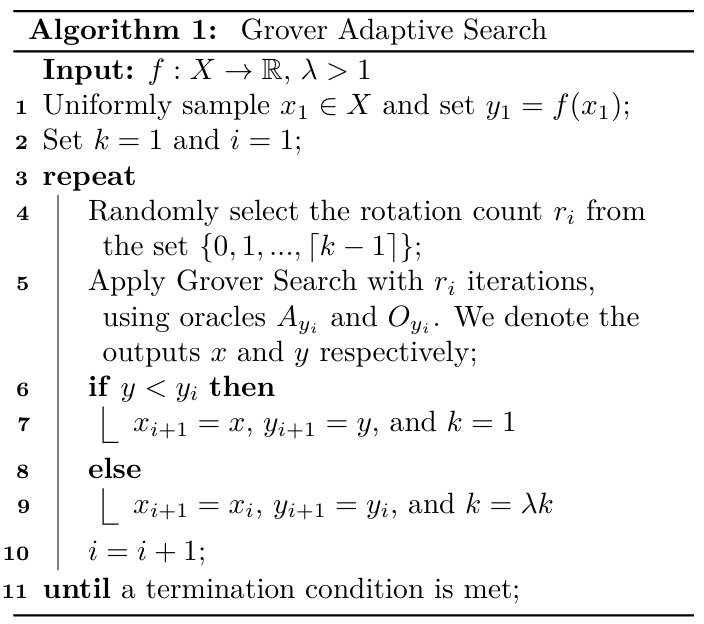

In [14]:
if colab:
    display(Image(filename = ruta_base + subruta + '7_pseudo.png'))
else:
    display(Image(filename='./Imágenes gas/7_pseudo.png'))

## 2. Implementación

Ahora vamos a ver cómo implementarlo en `Qiskit` y `docplex`. Lo único que tenemos que tener preparado es la *función objetivo* y las *restricciones*. Seguimos los siguientes pasos: 

- Creamos una instancia de modelo con `model = Model()`.
- Definimos las variables binarias así: `xi = model.binary_var(name="xi")` (una por variable).
- Definimos la función a minimizar a mano, por ejemplo: `model.minimize(a0 * x0 + a1 * x1 + a2 * x2 + a01 * x0 * x1 + a02 * x0 * x2 + a12 * x1 * x2)`, siendo `xi` las variables definidas antes. También admite `model.maximize(...)`.
- Añadimos las restricciones de igualdad (con `==`) o desigualdad (con `>=`, `>`, `<=` ó `<`), por ejemplo: `model.add_constraint(x0 + x1 >= 1)`, siendo `xi` las variables definidas antes.
- Pasamos el modelo a un formato que sí acepta qiskit con `qp = from_docplex_mp(model)`. 

In [28]:
# Modelo
model = Model()

# Variables
x0 = model.binary_var(name="x0")
x1 = model.binary_var(name="x1")
x2 = model.binary_var(name="x2")

# Función objetivo
model.maximize(-x0 + 2 * x1 - 3 * x2 - 2 * x0 * x2 - 1 * x1 * x2)

# Restricciones
model.add_constraint(x0 + x1 >= 1)
model.add_constraint(x2 == 1)

# Adaptación a modelo de Qiskit
qp = from_docplex_mp(model)
print(qp.prettyprint())

Problem name: docplex_model3

Maximize
  -2*x0*x2 - x1*x2 - x0 + 2*x1 - 3*x2

Subject to
  Linear constraints (2)
    x0 + x1 >= 1  'c0'
    x2 == 1  'c1'

  Binary variables (3)
    x0 x1 x2



Tenemos un último paso antes de poder ejecutar el GAS: determinar el número de cubits del registro de salida $m$. Para ello, calculamos el máximo valor absoluto que puede alcanzar la función objetivo y luego le sumamos dos cubits, uno por el signo y otro por el posible desbordamiento por ir añadiendo umbrales. 

Para calcular el máximo valor absoluto de la función objetivo, calculamos la suma de los coeficientes positivos y la suma de los negativos y nos quedamos con el mayor de ellos (recordar que al hacer el logaritmo en base 2 tenemos que redondear siempre el resultado hacia arriba, es decir, `int(resultado) + 1`). 

In [27]:
# Calcular el número m de cubits "value" para almacenar valores de las salidas de las funciones
# Conseguir coeficientes
linear_coeffs = list(qp.objective.linear.to_dict().values())
quadratic_coeffs = list(qp.objective.quadratic.to_dict().values())
coeffs = linear_coeffs + quadratic_coeffs
# Sumas de coeficientes según signos y calculo del numero de cubits
positivos = sum(i for i in coeffs if i > 0)
negativos = abs(sum(i for i in coeffs if i < 0))
num_qubits = int(np.log2(max(positivos, negativos))) + 1 + 2
print(num_qubits)

5


Instanciamos el algoritmo de Grover y lo ejecutamos tal que pare si tras `num_iterations` iteraciones no mejora el resultado.

In [29]:
# Instanciar y ejecutar modelo
grover_optimizer = GroverOptimizer(num_qubits, num_iterations=10, sampler=Sampler())
results = grover_optimizer.solve(qp)
print(results.prettyprint())

objective function value: -2.0
variable values: x0=0.0, x1=1.0, x2=1.0
status: SUCCESS
